In [90]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [91]:
transform = transforms.Compose([
    transforms.ToTensor(),  # image to tensor conversion
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize data
])

# load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

# Create data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=True, num_workers=4)

# classes for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


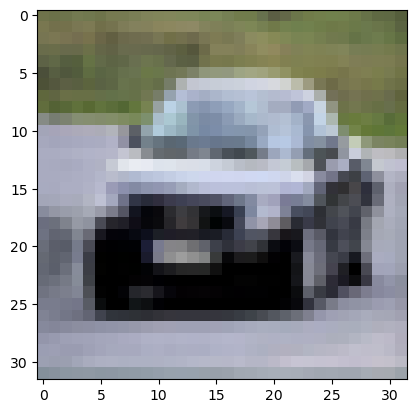

Label: automobile


In [126]:
def imshow(img):
    '''
    Show image in a xy-plot
    '''
    img = img / 2 + 0.5  # de-normalize data
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


train_data_iter = iter(trainloader)
images, labels = next(train_data_iter)

imshow(images[0])  # show image
print(f'Label: {classes[labels[0]]}')  # label

In [93]:
def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri - rk + 1,  ci - ck + 1
    output = torch.zeros([ro, co])

    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(
                image[i: i + rk, j: j + ck] * kernel)

    return output


sample_image = torch.tensor([[3, 3, 2, 1, 0],
                             [0, 0, 1, 3, 1],
                             [3, 1, 2, 2, 3],
                             [2, 0, 0, 2, 2],
                             [2, 0, 0, 0, 1]], dtype=torch.float32)

sample_kernel = torch.tensor([[0, 1, 2],
                             [2, 2, 0],
                             [0, 1, 2]], dtype=torch.float32)

sample_convolution = apply_kernel(sample_image, sample_kernel)
print(f'Convolution: {sample_convolution}')

Convolution: tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])


In [94]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

for images, labels in trainloader:
    print(f'Input shape: {images.shape}')
    print(f'Output shape: {simple_model(images).shape}')
    break

Input shape: torch.Size([128, 3, 32, 32])
Output shape: torch.Size([128, 8, 16, 16])


In [95]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [99]:
# helper class for training and validating model
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch}], train_loss: [{result["train_loss"]:.4f}], val_loss: [{result["val_loss"]:.4f}], val_acc: [{result["val_acc"]:.4f}]')

In [100]:
# single neural network
class CIFAR10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)


model = CIFAR10CnnModel()
print(f'{model}')

CIFAR10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [102]:
for images, labels in trainloader:
    print(f'Input shape: {images.shape}')
    print(f'Output shape: {model(images).shape}')
    print(f'Output shape: {model(images)[0]}')
    break

Input shape: torch.Size([128, 3, 32, 32])
Output shape: torch.Size([128, 10])
Output shape: tensor([-0.0152, -0.0012, -0.0086, -0.0424,  0.0112, -0.0207, -0.0243, -0.0402,
        -0.0185,  0.0330], grad_fn=<SelectBackward0>)


In [103]:
# get device info
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# move tensor to chosen device


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    # wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    # yield a batch of result after moving to a new device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    # numbers of batch
    def __len__(self):
        return len(self.dl)

In [104]:
device = get_default_device()
print(f'{device}')

cuda


In [105]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

to_device(model, device)

CIFAR10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [106]:
@torch.no_grad()  # disable gradient calculation -> no backward propagation is done
def evaluate(model: ImageClassificationBase, testloader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in testloader]

    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, trainloader, testloader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in trainloader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, testloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [107]:
model = to_device(CIFAR10CnnModel(), device)  # instantiating again
evaluate(model, testloader)

{'val_loss': 2.3027749061584473, 'val_acc': 0.10205078125}

In [108]:
# the initial accuracy is 10%
# to boost the accuracy, let us define some hyper-parameters

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [109]:
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: [1.6057], val_loss: [1.2220], val_acc: [0.5602]
Epoch [1], train_loss: [1.0712], val_loss: [0.9542], val_acc: [0.6645]
Epoch [2], train_loss: [0.8302], val_loss: [0.8325], val_acc: [0.7142]
Epoch [3], train_loss: [0.6529], val_loss: [0.7201], val_acc: [0.7535]
Epoch [4], train_loss: [0.5366], val_loss: [0.6690], val_acc: [0.7701]
Epoch [5], train_loss: [0.4251], val_loss: [0.6816], val_acc: [0.7767]
Epoch [6], train_loss: [0.3228], val_loss: [0.6987], val_acc: [0.7849]
Epoch [7], train_loss: [0.2457], val_loss: [0.7582], val_acc: [0.7854]
Epoch [8], train_loss: [0.1975], val_loss: [0.8196], val_acc: [0.7768]
Epoch [9], train_loss: [0.1589], val_loss: [0.9964], val_acc: [0.7736]


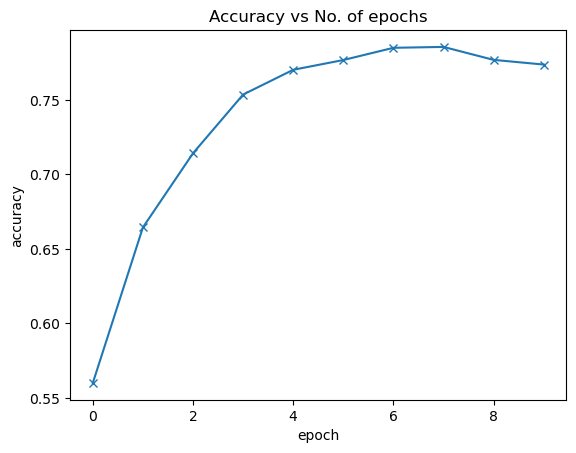

In [112]:
def plot_accuracy(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No. of epochs')


plot_accuracy(history)

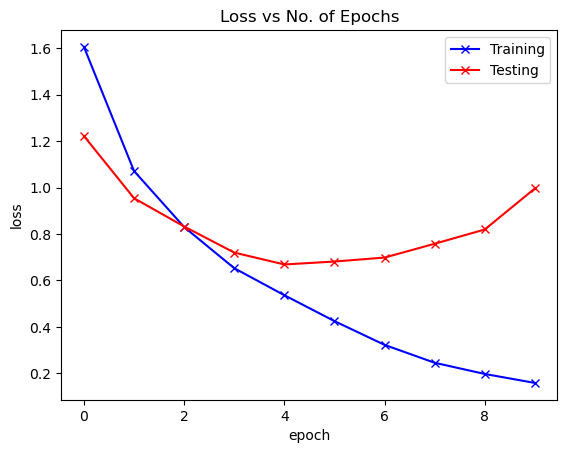

In [111]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    test_loss = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(test_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Testing'])
    plt.title('Loss vs No. of Epochs')


plot_losses(history)

In [138]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    
    _, preds = torch.max(yb, dim=1)
    return testset.classes[preds[0].item()]

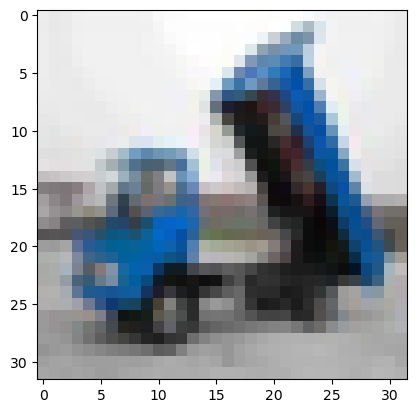

Label:  truck Predicted:  truck


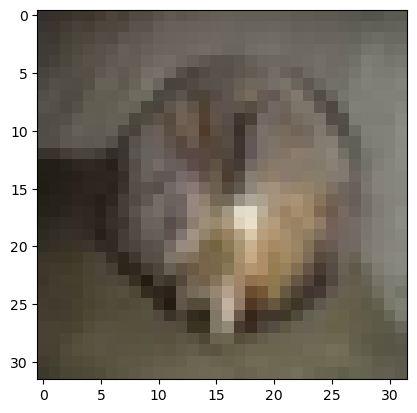

Label:  cat Predicted:  dog


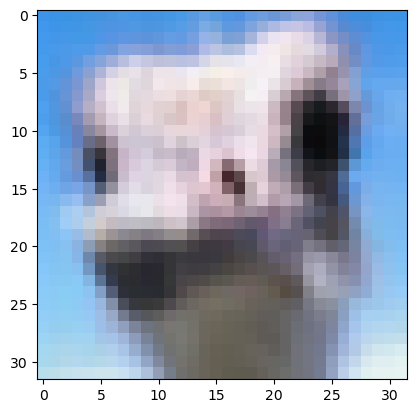

Label:  bird Predicted:  dog


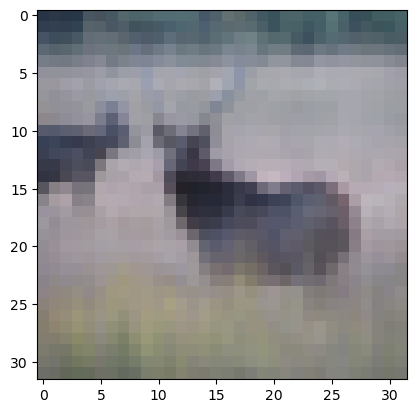

Label:  deer Predicted:  deer


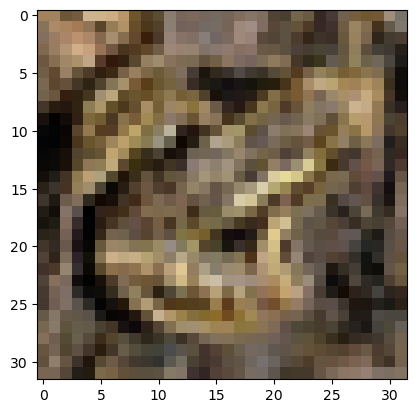

Label:  frog Predicted:  frog


In [139]:
test_data_iter = iter(testloader)
images, label = next(test_data_iter)

# testing classification with 5 images
for i in range(5):
    imshow(images[i])
    print('Label: ', testset.classes[label[i]],
          'Predicted: ', predict_image(images[i], model))

In [140]:
test_loader = DeviceDataLoader(torch.utils.data.DataLoader(testset, 256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.0075443983078003, 'val_acc': 0.770703136920929}

In [141]:
# save model
torch.save(model.state_dict(), 'cifar10-cnn.pth')